In [ ]:
!pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6ae23775ebf78605e53677621749c99fcde26225853b889a44504be8e9dfb037
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
import gdown
import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from efficientnet_pytorch import EfficientNet
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score
import librosa
from PIL import Image
import pathlib
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import keras
from keras import layers
from keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import keras.optimizers
import librosa.display
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import sys
import subprocess
import numpy as np
import glob
import json
import shutil
import pandas as pd

In [ ]:
!git clone https://github.com/iiscleap/Coswara-Data.git

Cloning into 'Coswara-Data'...
remote: Enumerating objects: 975, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 975 (delta 99), reused 151 (delta 78), pack-reused 798
Receiving objects: 100% (975/975), 15.97 GiB | 39.94 MiB/s, done.
Resolving deltas: 100% (409/409), done.
Checking out files: 100% (336/336), done.


In [ ]:
coswara_data_dir = os.path.abspath('/content/Coswara-Data') # Local Path of iiscleap/Coswara-Data Repo
extracted_data_dir = os.path.abspath('/content/Extracted_data')

if not os.path.exists(coswara_data_dir):
    raise("Check the Coswara dataset directory!")

if not os.path.exists(extracted_data_dir):
    os.makedirs(extracted_data_dir) # Creates the Extracted_data folder if it doesn't exist

dirs_extracted = set(map(os.path.basename,glob.glob('{}/202*'.format(extracted_data_dir))))
dirs_all = set(map(os.path.basename,glob.glob('{}/202*'.format(coswara_data_dir))))

dirs_to_extract = list(set(dirs_all) - dirs_extracted)

for d in dirs_to_extract:
    p = subprocess.Popen('cat {}/{}/*.tar.gz.* |tar -xvz -C {}/'.format(coswara_data_dir, d, extracted_data_dir), shell=True)
    p.wait()


print("Extraction process complete!")

Extraction process complete!


In [ ]:
df_sound = pd.read_csv('/content/Coswara-Data/combined_data.csv')
df_sound

,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,...,vacc,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia
0,iV3Db6t1T8b7c5HQY2TwxIhjbzD3,28,healthy,2020-04-23,y,male,India,Anantapur,Andhra Pradesh,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AxuYWBN0jFVLINCBqIW5aZmGCdu1,25,healthy,2020-04-20,y,male,India,BENGALURU URBAN,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C5eIsssb9GSkaAgIfsHMHeR6fSh1,28,healthy,2020-04-24,y,female,United States,Pittsburgh,Pennsylvania,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,YjbEAECMBIaZKyfqOvWy5DDImUb2,26,healthy,2020-04-23,y,male,India,Bangalore,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,32,healthy,2020-04-22,y,male,India,Nalanda,Bihar,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,333NjqA1TfZJuICEdXSkPhVz0LA3,48,positive_asymp,2021-07-13,y,male,India,Thondamuthur,Tamil Nadu,n,...,p,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
2742,dpA0EeRrtJUeKJjEuf7BL0AeTJZ2,36,positive_mild,2021-07-06,y,male,India,MSRMC,Karnataka,n,...,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,UXhG3vgoxkWtd4Meky1nm0sRgMV2,76,positive_mild,2021-07-13,y,male,India,Coimbatore,Tamil Nadu,n,...,y,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN
2744,A5KW9PXraNgckln1gnNaJnX6DvB2,25,positive_moderate,2021-07-01,y,male,India,Coimbatore,Tamil Nadu,n,...,p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_sound.covid_status.unique()

array(['healthy', 'no_resp_illness_exposed',
       'resp_illness_not_identified', 'positive_moderate',
       'recovered_full', 'positive_mild', 'positive_asymp',
       'under_validation'], dtype=object)

In [ ]:
df_sound['folder_name'] = df_sound['record_date'].str.replace('-', '')
df_sound

,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,...,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia,folder_name
0,iV3Db6t1T8b7c5HQY2TwxIhjbzD3,28,healthy,2020-04-23,y,male,India,Anantapur,Andhra Pradesh,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200423
1,AxuYWBN0jFVLINCBqIW5aZmGCdu1,25,healthy,2020-04-20,y,male,India,BENGALURU URBAN,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200420
2,C5eIsssb9GSkaAgIfsHMHeR6fSh1,28,healthy,2020-04-24,y,female,United States,Pittsburgh,Pennsylvania,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200424
3,YjbEAECMBIaZKyfqOvWy5DDImUb2,26,healthy,2020-04-23,y,male,India,Bangalore,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200423
4,aGOvk4ji0cVqIzCs1jHnzlw2UEy2,32,healthy,2020-04-22,y,male,India,Nalanda,Bihar,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20200422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,333NjqA1TfZJuICEdXSkPhVz0LA3,48,positive_asymp,2021-07-13,y,male,India,Thondamuthur,Tamil Nadu,n,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,20210713
2742,dpA0EeRrtJUeKJjEuf7BL0AeTJZ2,36,positive_mild,2021-07-06,y,male,India,MSRMC,Karnataka,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210706
2743,UXhG3vgoxkWtd4Meky1nm0sRgMV2,76,positive_mild,2021-07-13,y,male,India,Coimbatore,Tamil Nadu,n,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,20210713
2744,A5KW9PXraNgckln1gnNaJnX6DvB2,25,positive_moderate,2021-07-01,y,male,India,Coimbatore,Tamil Nadu,n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210701


In [ ]:
folder_lst = list(df_sound.folder_name.unique())
folder_lst

In [ ]:
grp_df = df_sound.groupby('folder_name')
grp_df.get_group('20210705')

,id,a,covid_status,record_date,ep,g,l_c,l_l,l_s,rU,...,bd,others_resp,ftg,st,ihd,asthma,others_preexist,cld,pneumonia,folder_name
2699,hCix5UmABWZVW40elRFgkGabPa52,40,positive,2021-07-05,y,male,India,Msrmc,Karnataka,n,...,True,NaN,True,NaN,NaN,NaN,NaN,NaN,True,20210705
2716,ygiPwZYsKFetOejhxWXB6rKSHAf2,66,positive,2021-07-05,y,male,India,Msrmc,Karnataka,n,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,20210705
2732,YKF05wLba6MKfUPRzQLyMYeCpgr2,53,positive,2021-07-05,y,male,India,Msrmc,Karnataka,n,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,20210705
2736,CA1MC050dVMX7ZOSRVYqYQKD2gF3,18,positive,2021-07-05,y,male,India,Msrmc,Karnataka,n,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210705


In [ ]:
pos_data_dir = os.path.abspath('/content/snd_data/Covid')
neg_data_dir = os.path.abspath('/content/snd_data/Healthy')
test_data_dir = os.path.abspath('/content/snd_data/Test')

if not os.path.exists(pos_data_dir):
    os.makedirs(pos_data_dir)

if not os.path.exists(neg_data_dir):
    os.makedirs(neg_data_dir)

if not os.path.exists(test_data_dir):
    os.makedirs(test_data_dir)

for i in folder_lst:
  dt_path = f'{extracted_data_dir}/{i}'
  if not os.path.exists(dt_path):
    continue
  temp_df = grp_df.get_group(i)
  for id in temp_df[temp_df['covid_status'] == 'positive']['id']:
    if not os.path.exists(f'{dt_path}/{id}'):
      continue
    shutil.copy(f'{dt_path}/{id}/cough-heavy.wav', f'{pos_data_dir}/{id}.wav')
  
  for id in temp_df[temp_df['covid_status'] == 'healthy']['id']:
    if not os.path.exists(f'{dt_path}/{id}'):
      continue
    shutil.copy(f'{dt_path}/{id}/cough-heavy.wav', f'{neg_data_dir}/{id}.wav')

  for id in temp_df[temp_df['covid_status'] == 'under_validation']['id']:
    if not os.path.exists(f'{dt_path}/{id}'):
      continue
    shutil.copy(f'{dt_path}/{id}/cough-heavy.wav', f'{test_data_dir}/{id}.wav')

In [ ]:
cases = 'Covid Healthy'.split()
for i in cases:
    pathlib.Path(f'img_data/{i}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/snd_data/{i}'):
      id = f'/content/snd_data/{i}/{filename}'
      y, sr = librosa.load(id, mono=True, duration=3, sr=None)
      if y.shape == (0,):
        continue
      else:
        librosa.feature.melspectrogram(y=y, sr=sr)
        D = np.abs(librosa.stft(y))**2
        S = librosa.feature.melspectrogram(S=D, sr=sr)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                          fmax=8000)
        fig, ax = plt.subplots()
        S_dB = librosa.power_to_db(S, ref=np.max)
        img = librosa.display.specshow(S_dB, x_axis='time',
                                      y_axis='mel', sr=sr,
                                      fmax=8000, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        plt.savefig(f'img_data/{i}/{filename[:-3].replace(".", "")}.png')

In [ ]:
path_dir = './img_data'
datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split = 0.2)
train_generator = datagen.flow_from_directory(
    path_dir,
    target_size=(150,150),
    shuffle=True,
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    path_dir,
    target_size=(150,150),
    subset='validation'
)

Found 457 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [ ]:

model = tf.keras.models.Sequential([
    #first_convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second_convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #third_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #fourth_convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax') 
]) 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_generator, batch_size=32,epochs=100)

Epoch 1/100
15/15 [==============================] - 13s 772ms/step - loss: 0.4563 - accuracy: 0.8556
Epoch 2/100
15/15 [==============================] - 12s 777ms/step - loss: 0.4430 - accuracy: 0.8687
Epoch 3/100
15/15 [==============================] - 12s 760ms/step - loss: 0.3868 - accuracy: 0.8687
Epoch 4/100
15/15 [==============================] - 12s 754ms/step - loss: 0.3876 - accuracy: 0.8687
Epoch 5/100
15/15 [==============================] - 12s 757ms/step - loss: 0.3815 - accuracy: 0.8687
Epoch 6/100
15/15 [==============================] - 12s 758ms/step - loss: 0.3756 - accuracy: 0.8687
Epoch 7/100
15/15 [==============================] - 12s 760ms/step - loss: 0.3667 - accuracy: 0.8687
Epoch 8/100
15/15 [==============================] - 12s 756ms/step - loss: 0.3658 - accuracy: 0.8687
Epoch 9/100
15/15 [==============================] - 12s 762ms/step - loss: 0.3439 - accuracy: 0.8687
Epoch 10/100
15/15 [==============================] - 12s 757ms/step - loss: 0.341

4/4 [==============================] - 2s 293ms/step - loss: 2.7196 - accuracy: 0.8509
n Test_Accuracy:- 0.8508771657943726
4/4 [==============================] - 1s 232ms/step
confusion matrix
[[  2   0]
 [  0 112]]


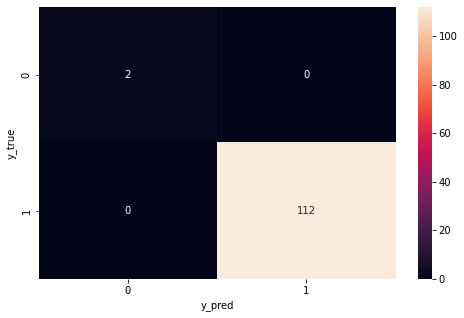

In [ ]:
accuracy = model.evaluate(validation_generator)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(validation_generator)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(y_true, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
model.save('./app/detectovid.h5')